# Political boundaries' matching

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union

## Utils

**merge_geometries**

In [89]:
def merge_geometries(df, column_name):
    df_new = pd.DataFrame(columns=list(df.columns))
    geom = []
    for value in tqdm(df[column_name].unique()):
        df_tmp = df[df[column_name] == value].iloc[:1]
        geom.append(cascaded_union(list(df[df[column_name] == value].geometry)))
        
        df_new = pd.concat([df_new, df_tmp])
        
    df_new.reset_index(inplace=True)
    df_new.drop(columns='index', inplace=True)
    df_new.drop(columns='geometry', inplace=True)
    df_new['geometry'] = geom

    return gpd.GeoDataFrame(df_new)

## GADM
### State:

In [2]:
gadm_state = gpd.read_file('../data/gadm36_USA/gadm36_USA_1.shp')
gadm_state.columns = map(str.lower, gadm_state.columns)
gadm_state = gadm_state[['gid_0', 'name_0', 'gid_1', 'name_1', 'geometry']]
gadm_state = gadm_state.reset_index(drop=True).reset_index()
gadm_state.head()

,index,gid_0,name_0,gid_1,name_1,geometry
0,0,USA,United States,USA.1_1,Alabama,"MULTIPOLYGON (((-87.97000 30.67667, -87.96972 ..."
1,1,USA,United States,USA.2_1,Alaska,"MULTIPOLYGON (((-179.13147 51.20972, -179.1322..."
2,2,USA,United States,USA.3_1,Arizona,"POLYGON ((-110.82376 31.33125, -110.82608 31.3..."
3,3,USA,United States,USA.4_1,Arkansas,"POLYGON ((-92.72461 33.01474, -92.86195 33.016..."
4,4,USA,United States,USA.5_1,California,"MULTIPOLYGON (((-118.58976 33.03865, -118.5897..."


(-180.0, -65.0)

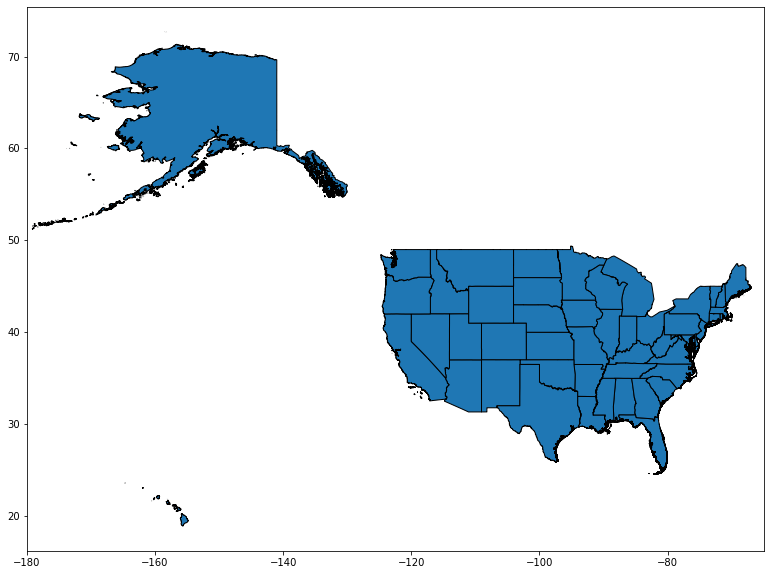

In [87]:
fig, ax = plt.subplots(figsize=(20, 10))
gadm_state.plot(ax=ax, edgecolor='black', facecolor=None)
plt.xlim(-180, -65)

### County:

In [3]:
gadm_county = gpd.read_file('../data/gadm36_USA/gadm36_USA_2.shp')
gadm_county.columns = map(str.lower, gadm_county.columns)
gadm_county = gadm_county[['gid_0', 'name_0', 'gid_1', 'name_1', 'gid_2', 'name_2', 'geometry']]
gadm_county = gadm_county.reset_index(drop=True).reset_index()
gadm_county.head()

,index,gid_0,name_0,gid_1,name_1,gid_2,name_2,geometry
0,0,USA,United States,USA.1_1,Alabama,USA.1.1_1,Autauga,"POLYGON ((-86.81896 32.34027, -86.81084 32.347..."
1,1,USA,United States,USA.1_1,Alabama,USA.1.2_1,Baldwin,"MULTIPOLYGON (((-87.51056 30.33972, -87.51083 ..."
2,2,USA,United States,USA.1_1,Alabama,USA.1.3_1,Barbour,"POLYGON ((-85.13026 31.76386, -85.13504 31.768..."
3,3,USA,United States,USA.1_1,Alabama,USA.1.4_1,Bibb,"POLYGON ((-87.42078 32.87446, -87.42028 32.971..."
4,4,USA,United States,USA.1_1,Alabama,USA.1.5_1,Blount,"POLYGON ((-86.95322 33.81542, -86.95449 33.845..."


(-180.0, -65.0)

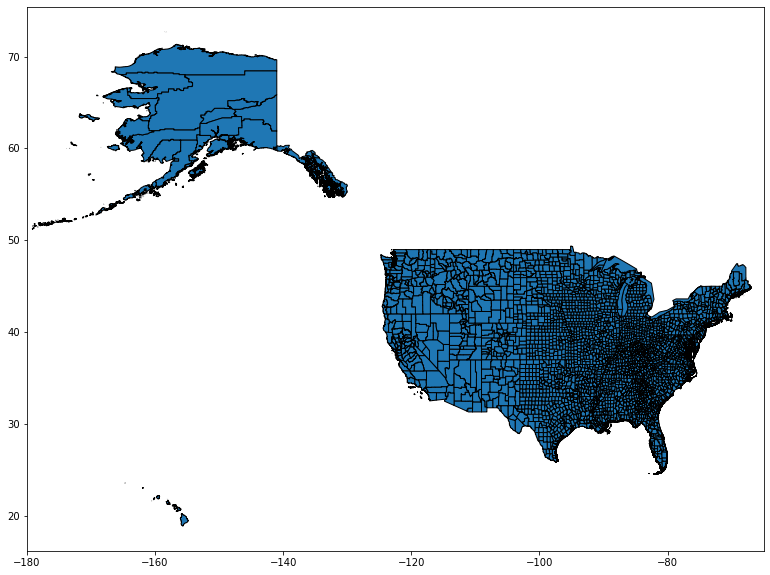

In [77]:
fig, ax = plt.subplots(figsize=(20, 10))
gadm_county.plot(ax=ax, edgecolor='black', facecolor=None)
plt.xlim(-180, -65)

## [United States Census Bureau](https://data.census.gov/cedsci/) 
### [States](https://www2.census.gov/geo/tiger/TIGER2019/STATE/):

In [5]:
state = gpd.read_file('../data/tl_2019_us_state/tl_2019_us_state.shp')
state.sort_values('GEOID', inplace=True)
# Remove Territories of the United States
state = state.iloc[:51]
state = state[['GEOID', 'STATEFP', 'NAME', 'geometry']]
state = state.set_crs(epsg=4326, allow_override=True)
state = state.to_crs("EPSG:4326")
state.head()

,GEOID,STATEFP,NAME,geometry
22,01,01,Alabama,"POLYGON ((-88.13999 34.58170, -88.13997 34.581..."
40,02,02,Alaska,"MULTIPOLYGON (((-165.25416 60.91711, -165.2630..."
55,04,04,Arizona,"POLYGON ((-114.51684 33.02789, -114.51699 33.0..."
43,05,05,Arkansas,"POLYGON ((-94.55217 36.10213, -94.55250 36.103..."
13,06,06,California,"MULTIPOLYGON (((-124.13656 41.46445, -124.1378..."


(-180.0, -65.0)

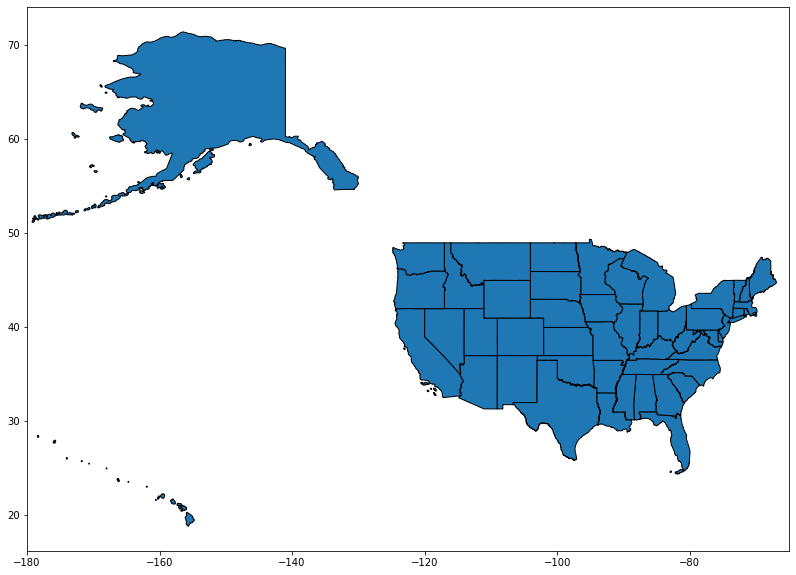

In [88]:
fig, ax = plt.subplots(figsize=(20, 10))
state.plot(ax=ax, edgecolor='black', facecolor=None)
plt.xlim(-180, -65)

### [County](https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/):

In [6]:
county = gpd.read_file('../data/tl_2019_us_county/tl_2019_us_county.shp')
county.sort_values('GEOID', inplace=True)
# Remove Territories of the United States
county = county[~county['STATEFP'].isin(['60','66','69', '72', '78'])]
# Add state name
county = pd.merge(county, state[['STATEFP', 'NAME']].rename(columns={'NAME': 'STNAME'}), on= 'STATEFP')
county = county[['GEOID', 'STATEFP', 'STNAME', 'NAME', 'NAMELSAD', 'geometry']]
county = county.set_crs(epsg=4326, allow_override=True)
county = county.to_crs("EPSG:4326")
county.head()

,GEOID,STATEFP,STNAME,NAME,NAMELSAD,geometry
0,01001,01,Alabama,Autauga,Autauga County,"POLYGON ((-86.90310 32.54063, -86.90311 32.540..."
1,01003,01,Alabama,Baldwin,Baldwin County,"POLYGON ((-87.99068 30.55549, -87.99051 30.560..."
2,01005,01,Alabama,Barbour,Barbour County,"POLYGON ((-85.42982 32.04598, -85.42985 32.046..."
3,01007,01,Alabama,Bibb,Bibb County,"POLYGON ((-87.31226 33.08622, -87.31218 33.087..."
4,01009,01,Alabama,Blount,Blount County,"POLYGON ((-86.74919 33.99760, -86.74902 33.997..."


(-180.0, -65.0)

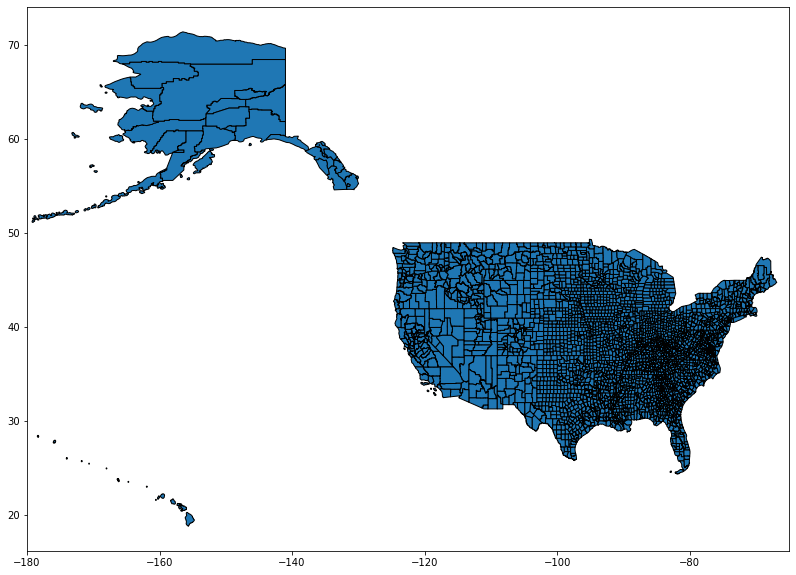

In [78]:
fig, ax = plt.subplots(figsize=(20, 10))
county.plot(ax=ax, edgecolor='black', facecolor=None)
plt.xlim(-180, -65)

## Solve city mismatch

**States with cities**

In [7]:
states_city = list(county[county['NAMELSAD'].str.contains("city")]['STNAME'].unique())
states_city

['Maryland', 'Missouri', 'Virginia']

In [8]:
state_city = state[state['NAME'].isin(states_city)].copy()
county_city = county[county['STNAME'].isin(states_city)].copy()
state_other = state[~state['NAME'].isin(states_city)].copy()
county_other = county[~county['STNAME'].isin(states_city)].copy()

gadm_state_city = gadm_state[gadm_state['name_1'].isin(states_city)].copy()
gadm_county_city = gadm_county[gadm_county['name_1'].isin(states_city)].copy()
gadm_state_other = gadm_state[~gadm_state['name_1'].isin(states_city)].copy()
gadm_county_other = gadm_county[~gadm_county['name_1'].isin(states_city)].copy()

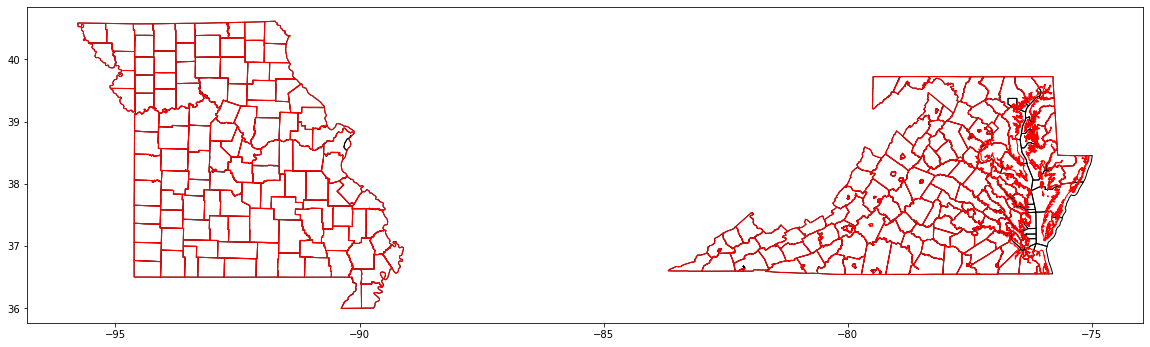

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
county_city.plot(ax=ax, facecolor="none", edgecolor='black')
gadm_county_city.plot(ax=ax, facecolor="none", edgecolor='r', lw=1)

**Maryland and Missouri**
- Same counties as in gadm + 1 city each
- We replace counties with gdam geometries 

In [10]:
county_MM = county_city[county_city['STNAME'].isin(states_city[:2])].copy()
county_V = county_city[county_city['STNAME'] == states_city[2]].copy()
gadm_county_MM = gadm_county_city[gadm_county_city['name_1'].isin(states_city[:2])].copy()
gadm_county_V = gadm_county_city[gadm_county_city['name_1'] == states_city[2]].copy()

In [11]:
geometries = []
for state_name in states_city[:2]:
    geoms = list(gadm_county_MM[gadm_county_MM['name_1'] == state_name]['geometry'])
    geoms += [county_MM[county_MM['STNAME'] == state_name].iloc[-1]['geometry']]
    
    geometries += geoms
    
county_MM['geometry'] = geometries

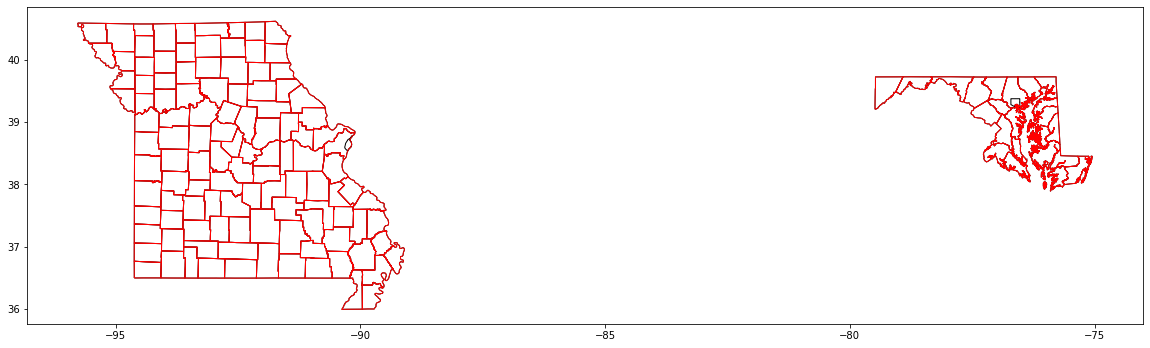

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
county_MM.plot(ax=ax, facecolor="none", edgecolor='black')
gadm_county_MM.plot(ax=ax, facecolor="none", edgecolor='r', lw=1)

**Virginia**

In [35]:
county_V = pd.merge(county_V[['GEOID','STATEFP', 'STNAME', 'NAME', 'NAMELSAD']], gadm_county_V[['name_2', 'geometry']], left_on=['NAME'], right_on=['name_2'], how='left').drop(columns='name_2')
county_V = gpd.GeoDataFrame(county_V)

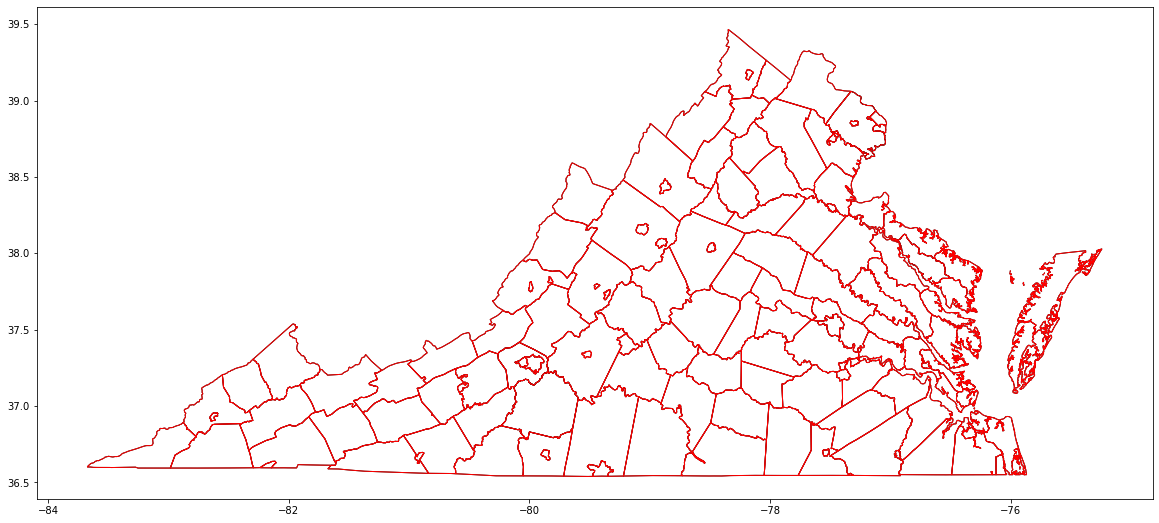

In [36]:
fig, ax = plt.subplots(figsize=(20, 10))
county_V.plot(ax=ax, facecolor="none", edgecolor='black')
gadm_county_V.plot(ax=ax, facecolor="none", edgecolor='r', lw=1)

**Concatenate cities**

In [37]:
county_city = pd.concat([county_MM, county_V])

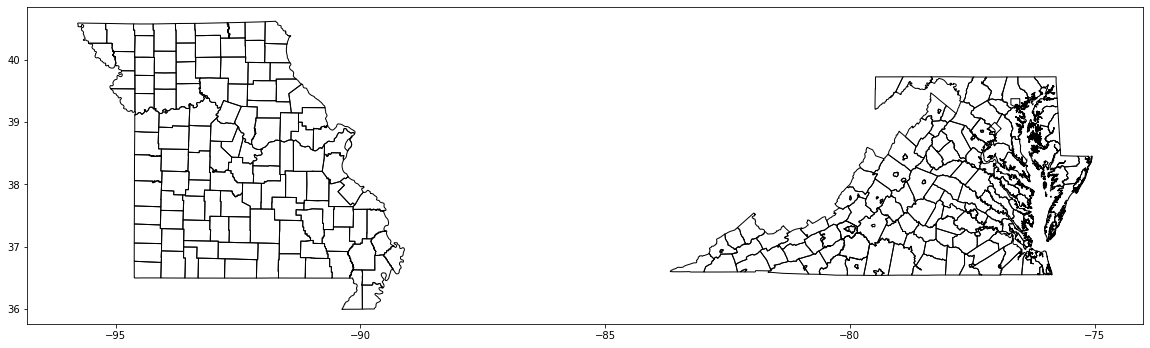

In [38]:
fig, ax = plt.subplots(figsize=(20, 10))
county_city.plot(ax=ax, facecolor="none", edgecolor='black')

## Solve county mismatch

**Number of counties in each state**

In [39]:
census = []
gadm = []
for state_name in state_other['NAME'].unique():
    census.append(len(county_other[county_other['STNAME'] == state_name]))
    gadm.append(len(gadm_county_other[gadm_county_other['name_1'] == state_name]))

In [40]:
state_other['match'] = list(np.array(census) == np.array(gadm))
state_other['county_diff'] = list(np.array(census) - np.array(gadm))

**Take counties that match and replace census geometries with gadm ones**

In [41]:
county_match = county_other[county_other['STNAME'].isin(list(state_other[state_other['match'] == True]['NAME']))].copy()
gadm_county_match = gadm_county_other[gadm_county_other['name_1'].isin(list(state_other[state_other['match'] == True]['NAME']))].copy()
county_match['geometry'] = list(gadm_county_match['geometry'])

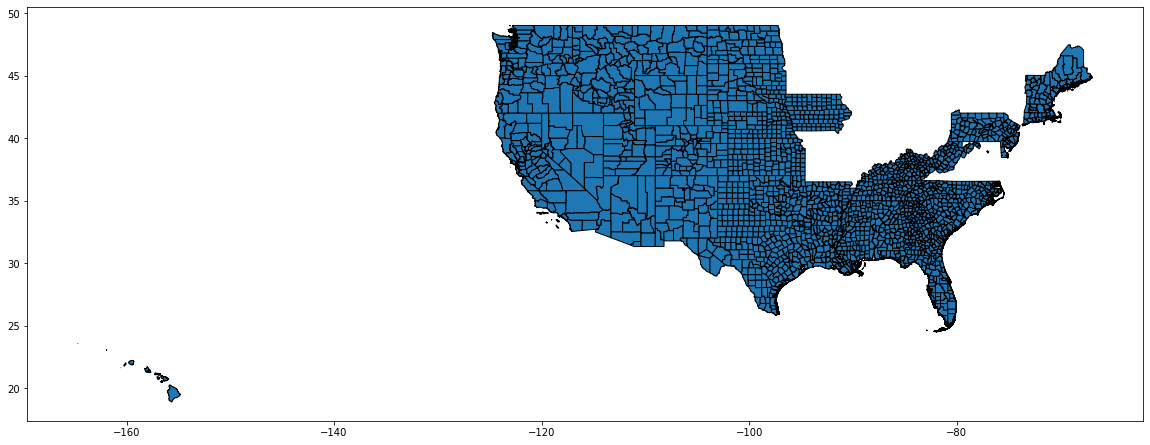

In [42]:
fig, ax = plt.subplots(figsize=(20, 10))
county_match.plot(ax=ax, edgecolor='black')

**States where counties mismatch**

In [44]:
state_other[state_other['match'] == False]

,GEOID,STATEFP,NAME,geometry,match,county_diff
40,02,02,Alaska,"MULTIPOLYGON (((-165.25416 60.91711, -165.2630...",False,3
2,17,17,Illinois,"POLYGON ((-91.18529 40.63780, -91.17510 40.643...",False,-1
48,18,18,Indiana,"POLYGON ((-87.52659 40.47688, -87.52658 40.478...",False,-1
42,26,26,Michigan,"POLYGON ((-86.46412 45.32481, -86.46452 45.324...",False,-4
3,27,27,Minnesota,"POLYGON ((-96.78438 46.63050, -96.78434 46.630...",False,-1
38,36,36,New York,"MULTIPOLYGON (((-79.31214 42.68680, -79.24977 ...",False,-1
24,39,39,Ohio,"POLYGON ((-84.80325 40.98939, -84.80324 40.991...",False,-1
15,55,55,Wisconsin,"POLYGON ((-92.88707 45.64415, -92.88671 45.644...",False,-2


In [45]:
county_mismatch = county_other[county_other['STNAME'].isin(list(state_other[state_other['match'] == False]['NAME']))].copy()
gadm_county_mismatch = gadm_county_other[gadm_county_other['name_1'].isin(list(state_other[state_other['match'] == False]['NAME']))].copy()

In [46]:
df1 = pd.merge(county_mismatch, gadm_county_mismatch, left_on=['STNAME','NAME'], right_on=['name_1', 'name_2'], how='left')
county_mismatch_match = df1[~df1['name_2'].isnull()]
county_mismatch_match = county_mismatch_match[['GEOID', 'STATEFP', 'STNAME', 'NAME', 'NAMELSAD', 'geometry_x']].rename(columns={'geometry_x': 'geometry'})
county_mismatch_match = gpd.GeoDataFrame(county_mismatch_match)

df1 = df1[df1['name_2'].isnull()]
df1 = df1[['GEOID', 'STATEFP', 'STNAME', 'NAME', 'NAMELSAD', 'geometry_x']].rename(columns={'geometry_x': 'geometry'})
df1 = gpd.GeoDataFrame(df1)

In [47]:
df2 = pd.merge(gadm_county_mismatch, county_mismatch, left_on=['name_1', 'name_2'], right_on=['STNAME','NAME'], how='left')
gadm_county_mismatch_match = df2[~df2['NAME'].isnull()]
gadm_county_mismatch_match = gadm_county_mismatch_match[['index', 'gid_0', 'name_0', 'gid_1', 'name_1', 'gid_2', 'name_2','geometry_x']].rename(columns={'geometry_x': 'geometry'})
gadm_county_mismatch_match = gpd.GeoDataFrame(gadm_county_mismatch_match)

df2 = df2[df2['NAME'].isnull()]
df2 = df2[['index', 'gid_0', 'name_0', 'gid_1', 'name_1', 'gid_2', 'name_2','geometry_x']].rename(columns={'geometry_x': 'geometry'})
df2 = gpd.GeoDataFrame(df2)

Replace census geometries with gadm ones

In [48]:
county_mismatch_match['geometry'] = list(gadm_county_mismatch_match['geometry'])

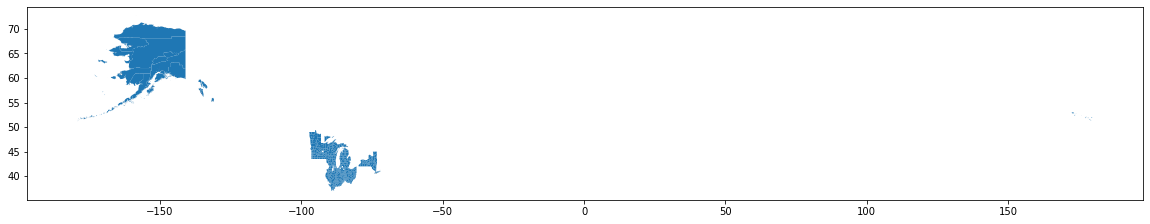

In [50]:
fig, ax = plt.subplots(figsize=(20, 10))
county_mismatch_match.plot(ax=ax)

**Intersect the geometries that mismatch**

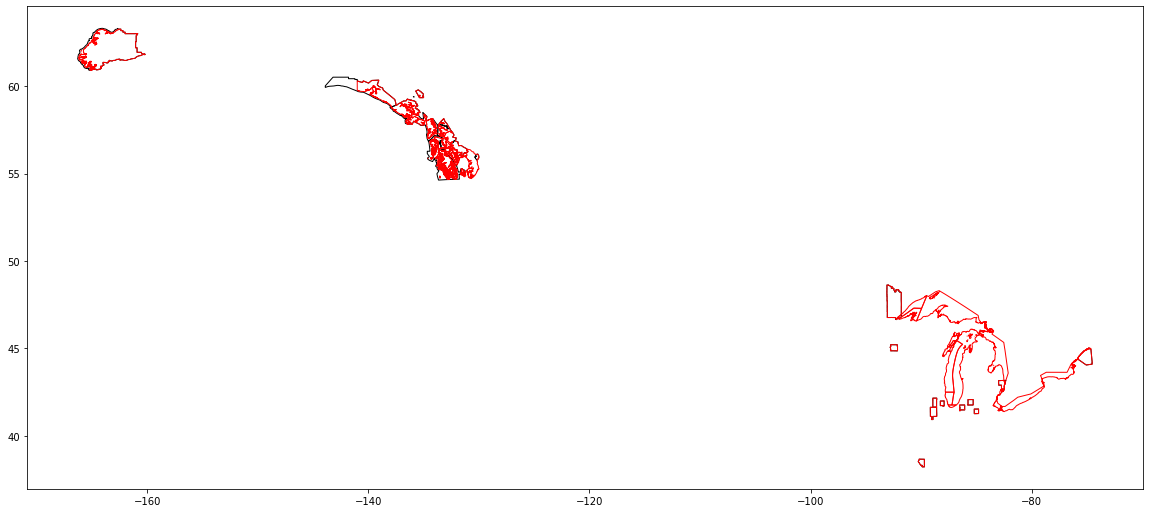

In [51]:
fig, ax = plt.subplots(figsize=(20, 10))
df1.plot(ax=ax, facecolor="none", edgecolor='black')
df2.plot(ax=ax, facecolor="none", edgecolor='r', lw=1)

In [52]:
df = gpd.overlay(df1, df2, how='intersection')
df = df[['GEOID', 'STATEFP', 'STNAME', 'NAME', 'NAMELSAD', 'geometry']]

**Merge same county geometries**

In [54]:
df_new = merge_geometries(df, 'NAME')

100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


(-180.0, -65.0)

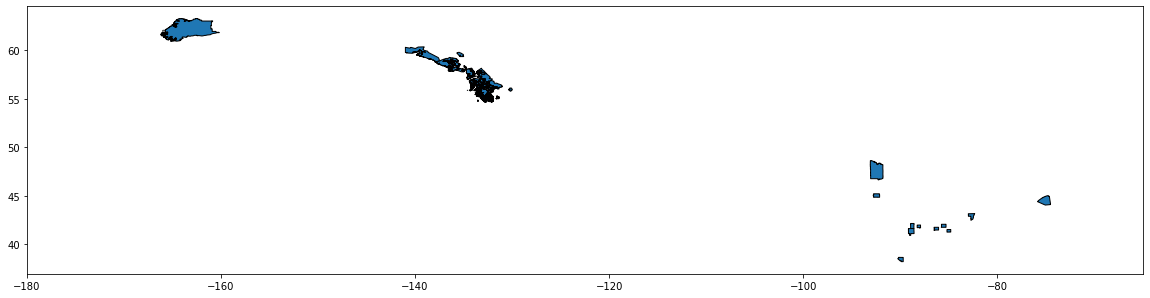

In [55]:
fig, ax = plt.subplots(figsize=(20, 10))
df_new.plot(ax=ax, edgecolor='black')
plt.xlim(-180, -65)

**Add geometris that don't intersect with gadm**

In [61]:
df1_mismatch = pd.merge(df1, df_new[['STATEFP', 'STNAME', 'NAME', 'NAMELSAD']], on = ['STNAME', 'NAME', 'NAMELSAD'], how='left')
df1_mismatch = df1_mismatch[df1_mismatch['STATEFP_y'].isnull()]
df1_mismatch = df1_mismatch.drop(columns='STATEFP_y').rename(columns={'STATEFP_x': 'STATEFP'})
df1_mismatch

,GEOID,STATEFP,STNAME,NAME,NAMELSAD,geometry
11,18033,18,Indiana,DeKalb,DeKalb County,"POLYGON ((-85.19295 41.38001, -85.19296 41.381..."
13,26147,26,Michigan,St. Clair,St. Clair County,"POLYGON ((-82.64328 43.16400, -82.64319 43.164..."
14,26149,26,Michigan,St. Joseph,St. Joseph County,"POLYGON ((-85.76121 41.98349, -85.76150 41.998..."


In [58]:
df2.loc[[143, 299, 300]]

,index,gid_0,name_0,gid_1,name_1,gid_2,name_2,geometry
143,709,USA,United States,USA.15_1,Indiana,USA.15.15_1,De Kalb,"POLYGON ((-85.19350 41.26429, -85.19431 41.351..."
299,1306,USA,United States,USA.23_1,Michigan,USA.23.78_1,Saint Clair,"MULTIPOLYGON (((-82.98389 42.89394, -82.98696 ..."
300,1307,USA,United States,USA.23_1,Michigan,USA.23.79_1,Saint Joseph,"POLYGON ((-85.29134 41.76061, -85.57629 41.760..."


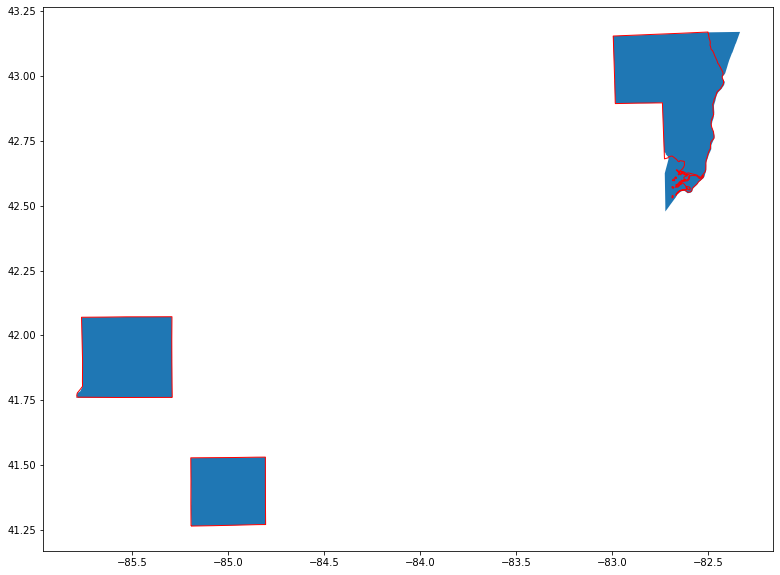

In [62]:
fig, ax = plt.subplots(figsize=(20, 10))
df1_mismatch.plot(ax=ax)
df2.loc[[143, 299, 300]].plot(ax=ax, facecolor="none", edgecolor='r', lw=1)

**Replace with gadm geometries**

In [63]:
df1_mismatch['geometry'] = list(df2.loc[[143, 299, 300]]['geometry'])

## Concatenate all counties

In [74]:
df_new = df_new.set_crs(epsg=4326, allow_override=True)
df_new = df_new.to_crs("EPSG:4326")
county_new = pd.concat([county_city, county_match, county_mismatch_match, df_new, df1_mismatch])

(-180.0, -65.0)

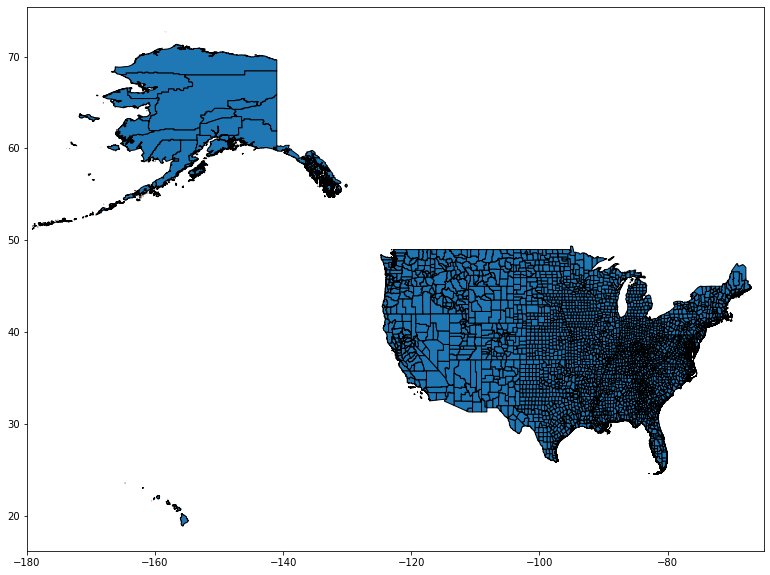

In [76]:
fig, ax = plt.subplots(figsize=(20, 10))
county_new.plot(ax=ax, edgecolor='black', facecolor=None)
plt.xlim(-180, -65)

## Save new geometries
`County`:

In [85]:
county_new.sort_values('GEOID', inplace=True)
county_new.to_file('../data/2019_us_county/2019_us_county.shp')

`State`:

In [91]:
states_new = merge_geometries(county_new, 'STNAME')

100%|██████████| 51/51 [1:36:17<00:00, 113.29s/it]   


In [95]:
state['geometry'] = list(states_new['geometry'])

In [98]:
state.to_file('../data/2019_us_state/2019_us_state.shp')

(-180.0, -65.0)

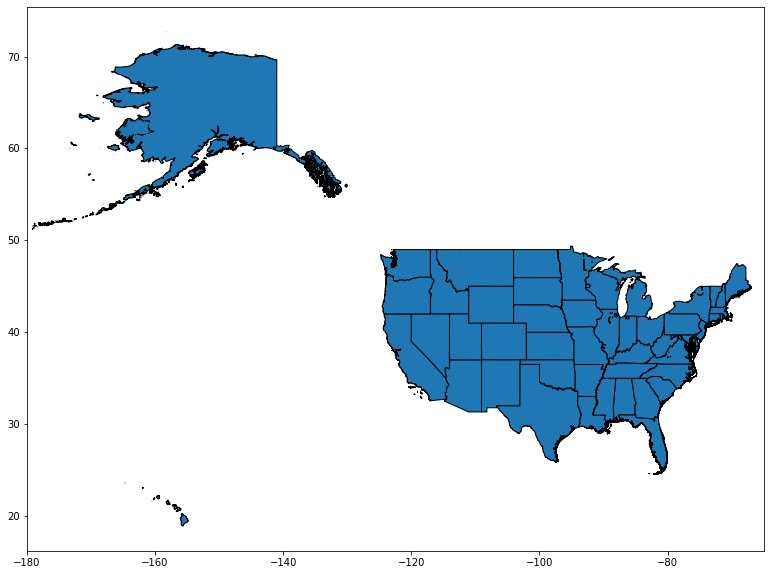

In [97]:
fig, ax = plt.subplots(figsize=(20, 10))
state.plot(ax=ax, edgecolor='black', facecolor=None)
plt.xlim(-180, -65)